In [3]:
""" import useful functions """

import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
import scipy
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

ModuleNotFoundError: No module named 'pyccl'

In [2]:
""" define functions """

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    # Wang and Mota
    dEdz = Omega_k *(1 + z)/E(z , cosmo) + ((3 * Omega_m * (1 + z) ** 2)+(4 * (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 3))/\
           (2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives rho_cdm / rho_DE as a function of z for k = 0


def rho_cdm_frac_rho_de(z , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    frac = Omega_c * (1+z) ** 3 / (Omega_lambda - alpha_tilde*(E_eval ** 4 - 2 * Omega_k * E_eval ** 2 * (1 + z) ** 2))
    return frac

# find w = P / pho for dark energy   -- for k = 0


def omega_de(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    ans = - 1 - (4 * alpha_tilde * (1 + z) * E_eval ** 3 * dEdz(z , cosmo)) / \
                (3 * (Omega_lambda - alpha_tilde*(E_eval ** 4)))
    
    return ans

def unitless_time(z , cosmo):
    t = np.zeros(len(z))
    for i in range(len(z)):
        t[i] = scipy.integrate.quad(lambda x: 1/(x*E(1/x -1,cosmo)), 0 , 1/(1+z[i]))[0]
    return t

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + 3*x/4))), a_min, 1/(1+z))[0]

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)), a_min, 1/(1+z))[0]

In [4]:
# SNe processed data for E(z) (with no correlation)

z_dat = np.array([0.07,0.2,0.35,0.55,0.9,1.5])

E_err = np.array([0.023,0.02,0.037,0.063,0.12,0.83])

E_dat = np.array([0.997,1.111,1.128,1.364,1.52,2.67])

In [12]:
'''cosmological parameters except alpha'''

Omg_rad = 5.44e-5 * 3.046 * (7/8) * (4/11)**(4/3)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

#define a and z intervals
z = np.linspace(0, 3 , int(1e3))
a = 1/(1+z)

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

/tmp/ipykernel_64317/3223050626.py:29: RuntimeWarning: invalid value encountered in sqrt
  ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))


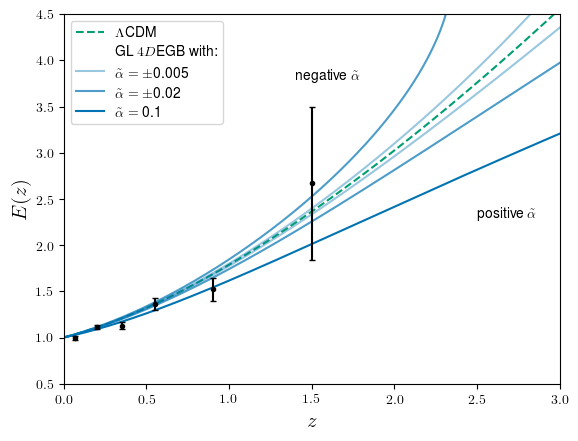

In [15]:
'''Plots of E(z)'''

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

plt.plot(z,E(z , cosmoLCDM), color = col[2],linestyle= "--", label = r"$\Lambda$CDM")

plt.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} = \pm$'+ str(cosmo[-2]))

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} = \pm$'+ str(cosmo[-2]))

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-1, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))

# -------
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -5e-3, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.7)

plt.text(2.5, 2.3, r"positive $\tilde{\alpha}$", fontfamily = "Helvetica")
plt.text(1.4, 3.8, r"negative $\tilde{\alpha}$", fontfamily = "Helvetica")

plt.errorbar(z_dat, E_dat, yerr=E_err, fmt=".k", capsize=2)
plt.xlabel(r"$z$", size = 15)
plt.ylabel(r"$E(z)$", size = 15);
plt.xlim(0,3)
plt.ylim(0.5,4.5)

plt.legend()
#plt.savefig("E_z_GL_paper.pdf")


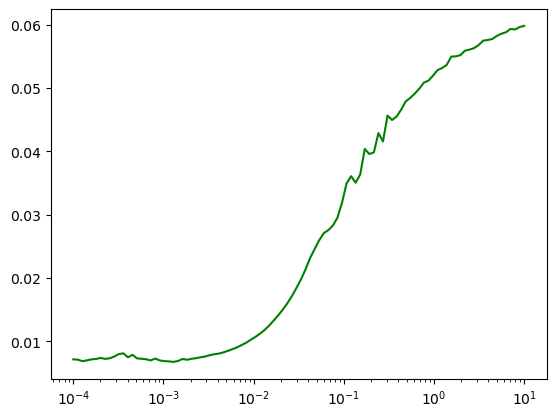

In [351]:
plt.plot(matterpower[0],(matterpower[1]- matterpower3[1])/matterpower[1],color="g")

plt.xscale("log")
#plt.yscale("log")


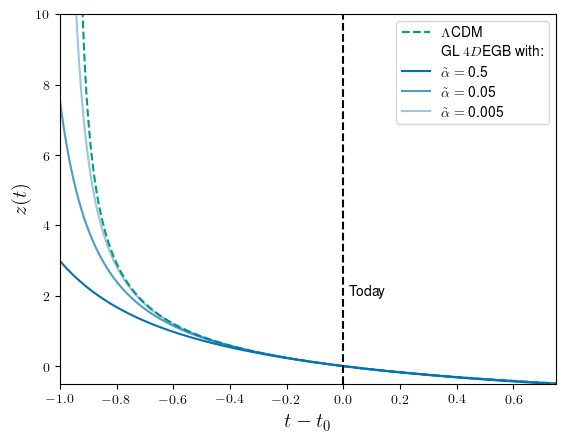

In [16]:
'''Plots of z(t)'''

z = np.linspace(-0.5, 10 , int(1e3))

plt.plot(unitless_time(z,cosmoLCDM) - unitless_time([0,0],cosmoLCDM)[0],z, color = col[2],linestyle= "--", label = r"$\Lambda$CDM")

plt.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-1, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-2, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
plt.plot(np.zeros(len(z)), z, "--k")
plt.text(0.02, 2.0, "Today", fontfamily = "Helvetica")

plt.xlabel(r"$t - t_0$", size = 15)
plt.ylabel(r"$z(t)$", size = 15);
plt.legend()
plt.xlim(-1,0.75)
plt.ylim(-0.5,10)

#plt.savefig("z_of_t_paper.pdf")
plt.show()

In [17]:
'''Plots of Sound Horizon'''

#Find quantities
a_LCDM = np.linspace(2e-9,1.5, int(1e3))
a = np.linspace(2e-9,1.5, int(1e3))

r_s_LCDM = np.zeros(len(a))
r_s1 = np.zeros(len(a))
r_s2 = np.zeros(len(a))
r_s3 = np.zeros(len(a))
for i in range(len(a)):
    r_s_LCDM[i] = r_s_fracH0c(1/a_LCDM[i] - 1,cosmoLCDM, 2e-9)
    cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 5e-10, 0]
    r_s1[i] = r_s_fracH0c(1/a[i] - 1 , cosmo1, 2e-9)
    cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-11, 0]
    r_s2[i] = r_s_fracH0c(1/a[i] - 1 , cosmo2, 2e-9)
    cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-12, 0]
    r_s3[i] = r_s_fracH0c(1/a[i] - 1 , cosmo3, 2e-9)

/tmp/ipykernel_64317/3223050626.py:87: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + 3*x/4))), a_min, 1/(1+z))[0]
/tmp/ipykernel_64317/3223050626.py:87: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + 3*x/4))), a_min, 1/(1+z))[0]


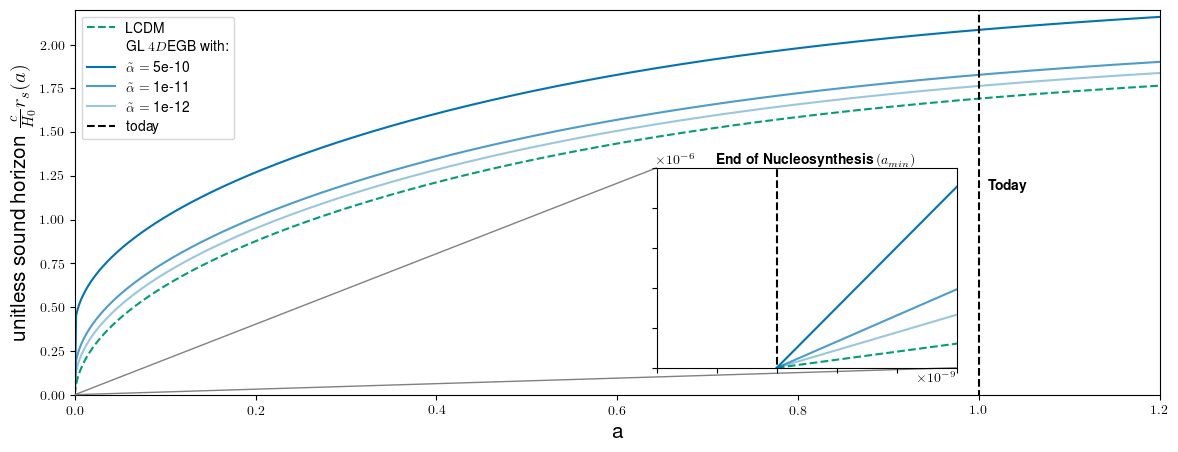

In [21]:
# Plot
fig = plt.figure(figsize=(14,5))
ax = plt.axes()

#big plot
ax.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
ax.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")
ax.plot(a,r_s1, color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo1[-2]))
ax.plot(a,r_s2, color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo2[-2]))
ax.plot(a,r_s3, color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo3[-2]))
ax.plot(np.ones(int(1e2)), np.linspace(-1,3, int(1e2)), "k--", label = "today")

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax, 80, loc=4) # zoom = 2
axins = inset_axes(ax, 3,2 , loc=4, bbox_to_anchor=(0.76, 0.15),bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
axins.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")
axins.plot(a,r_s1, color = col[0], alpha = 1)
axins.plot(a,r_s2, color = col[0], alpha = 0.7)
axins.plot(a,r_s3, color = col[0], alpha = 0.4)
axins.plot(2e-9*np.ones(int(1e2)), np.linspace(-1,3, int(1e2)), "k--")

axins.set_xlim(0, 5e-9)
axins.set_ylim(0, 1e-6)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(1.01, 1.17, r"$\textbf{Today}$", fontfamily = "Helvetica")
axins.text(5e-9/5,1.025e-6, r"$\textbf{End of Nucleosynthesis }  (\large a_{min})$", fontfamily = "Helvetica")

ax.set_xlabel("a", size = 15)
ax.set_ylabel(r"unitless sound horizon $\frac{c}{H_0}r_s(a)$", size = 15)
ax.set_ylim(0,2.2)
ax.set_xlim(0,1.2)
ax.legend()
plt.draw()
#plt.savefig("soundhorizon_paper.pdf")
plt.show()